In [1]:
import os
import json
import pandas as pd
import getpass
import re

from langchain_openai import ChatOpenAI
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, RemoveMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain.tools import BaseTool, StructuredTool, tool

from pydantic import BaseModel, Field
from typing import Literal, Dict, Tuple, List, Optional, TypedDict, Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
import operator

from llm_utils import get_llm

import itertools
import ast
from IPython.display import display, Markdown
import gradio as gr

import time

from dotenv import load_dotenv
load_dotenv("/home/jovyan/vol-2/.env")

os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY")
os.environ["SLIP_AUTH_URL"] = os.environ.get("SLIP_AUTH_URL")
os.environ["SLIP_USERNAME"] =os.environ.get("SLIP_USERNAME")
os.environ["SLIP_PASSWORD"] =  os.environ.get("SLIP_PASSWORD")
os.environ["SLIP_CLIENT_ID"]= os.environ.get("SLIP_CLIENT_ID")
os.environ["SLIP_APP_NAME"]=os.environ.get("SLIP_APP_NAME")

/home/jovyan/.conda/envs/ChatWithMedicalRecords/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We will save memory with sqlite saver
os.environ["TAVILY_API_KEY"] = "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"
tavily = TavilySearchResults(max_results=2)

In [3]:
df=pd.read_csv('/home/jovyan/vol-2/Roja/ds-ihan/v2/LLM_Agents/data/data_LLM.csv')

In [4]:
df=df[['id','dos','code','codeDesc','type','value']]

In [5]:
df.rename(columns={'id':'mcid'},inplace=True)

In [6]:
df.head()

,mcid,dos,code,codeDesc,type,value
0,1,2017-02-08,I10,Essential (primary) hypertension,diag,NaN
1,1,2017-02-08,I739,"Peripheral vascular disease, unspecified",diag,NaN
2,1,2017-02-08,M179,"Osteoarthritis of knee, unspecified",diag,NaN
3,1,2017-02-08,Z0000,Encounter for general adult medical examinatio...,diag,NaN
4,1,2017-05-17,E119,Type 2 diabetes mellitus without complications,diag,NaN


In [7]:
df['type'].value_counts()

type
diag      13025
proc       9500
lab        8847
rx         6112
age         100
gender      100
Name: count, dtype: int64

In [8]:
df['mcid'].unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,  995,  996,  997,  998,  999,
       1000])

In [9]:
# df['mcid']=df['mcid'].replace({408478586:0, 306342414:1, 406438406:2, 447442962:3, 432654279:4,  49958862:5,
#        360382072:6})

In [10]:
df['type'].value_counts()

type
diag      13025
proc       9500
lab        8847
rx         6112
age         100
gender      100
Name: count, dtype: int64

In [11]:
df_diag=df[df['type']=='diag']
df_proc=df[df['type']=='proc']
df_rx=df[df['type']=='rx']
df_lab=df[df['type']=='lab']

In [12]:
# The normal mapping between ICD10 and ICD10 full description
dict_obj_diag = df_diag[['code', 'codeDesc']].dropna().set_index('code')['codeDesc'].to_dict()
dict_obj_rx = df_rx[['code', 'codeDesc']].dropna().set_index('code')['codeDesc'].to_dict()
dict_obj_proc = df_proc[['code', 'codeDesc']].dropna().set_index('code')['codeDesc'].to_dict()
dict_obj_lab = df_lab[['code', 'codeDesc']].dropna().set_index('code')['codeDesc'].to_dict()

In [13]:
CKD_Diabetes_Mapping=pd.read_csv('/home/jovyan/vol-1/Albert/CKD_Diabetes_Mapping.csv')

In [14]:
CKD_Diabetes_Mapping

,Diagnosis Code,Description,Disease,Unnamed: 3,Unnamed: 4
0,N170,Acute kidney failure with tubular necrosis,Kidney Disease,NaN,NaN
1,N171,Acute kidney failure with acute cortical necrosis,Kidney Disease,NaN,NaN
2,N172,Acute kidney failure with medullary necrosis,Kidney Disease,NaN,NaN
3,N178,Other acute kidney failure,Kidney Disease,NaN,NaN
4,N179,"Acute kidney failure, unspecified",Kidney Disease,NaN,NaN
...,...,...,...,...,...
754,E13649,Other specified diabetes mellitus with hypogly...,Diabetes,NaN,NaN
755,E1365,Other specified diabetes mellitus with hypergl...,Diabetes,NaN,NaN
756,E1369,Other specified diabetes mellitus with other s...,Diabetes,NaN,NaN
757,E138,Other specified diabetes mellitus with unspeci...,Diabetes,NaN,NaN


In [15]:
# The common disease mapping dictionary
dict_disease_mapping = CKD_Diabetes_Mapping[['Diagnosis Code', 'Disease']].dropna().set_index('Diagnosis Code')['Disease'].to_dict()

In [16]:
# Works for diagnosis, rx, and procedure
def getDatesCodes(codeHistory):

    output = codeHistory.groupby('dos')['code'].apply(list).reset_index()
    output_dict = output.set_index('dos')['code'].to_dict()   
    dates= list(output_dict.keys())
    codes= list(output_dict.values())
    
    return dates, codes

In [17]:
# Lab needs a custom getter
def getLabDatesCodes(labHistory):
    dates = []
    code_value_pairs = []
    output = labHistory.groupby('dos').agg({'code':list,'value':list})
    for idx,row in output.iterrows():
        dates.append(idx)
        code_value_pairs.append({code:round(value,2) for code ,value in zip(row['code'],row['value'])})
    
    return dates, code_value_pairs      

In [18]:
def getPatientDatesCodes(mcid):
    rtn = []
    rtn.append(getDatesCodes(df_diag[df_diag['mcid']==mcid]))
    rtn.append(getLabDatesCodes(df_lab[df_lab['mcid']==mcid]))
    rtn.append(getDatesCodes(df_proc[df_proc['mcid']==mcid]))
    rtn.append(getDatesCodes(df_rx[df_rx['mcid']==mcid]))
    return rtn

In [19]:
from typing import List, Dict

@tool
def returnSpecificICD10DatesCodes(patient_codes_list: List[List[str]], dates_list: List[str], codes_disease_dictionary_mapping: Dict[str, str], diseaseSearch: str) -> Tuple[List[str], List[List[str]], List[str]]:
    """returns the patient's specific ICD10 codes and dates for the disease searched based on their existing dates and codes."""
    # Extract the specific disease codes from the dictionary mapping
    check = set([code for code, disease in codes_disease_dictionary_mapping.items() if disease == diseaseSearch])
    #print(check)

    filtered_dates = []
    filtered_code_lists = []
    specificDiseaseCodesFound = set()

    # Filtering the dates and code lists based on the disease search
    for i, codes in enumerate(patient_codes_list):
        intersection = set(codes) & check
        #print(intersection)
        if intersection:
            filtered_code_lists.append(list(intersection))
            filtered_dates.append(dates_list[i])
            specificDiseaseCodesFound.update(intersection)

    return filtered_dates, filtered_code_lists, list(specificDiseaseCodesFound)

In [20]:
# create codes in alphanumeric order.

# lookup_dict is like : Dict[str, str]
@tool
def createLookupTable(codes: List[List[str]], lookup_dict) -> str:
    """Create the codes and descriptions lookup table for the specific patient."""
    
    flattened_list = [item for sublist in codes for item in sublist]
    
    # get unique codes, which are keys in lookup_dict
    unique_codes = set(flattened_list) & lookup_dict.keys()
    
    # sort codes in alphanumeric order
    sorted_unique_codes = sorted(unique_codes)
    print(sorted_unique_codes)
    
    # join each code and its description in a string, separated by ":"
    formatted_string = "\n".join(f"{code}: {lookup_dict[code]}" for code in sorted_unique_codes)

    return formatted_string

In [21]:
from typing import List, Dict

@tool
def createLabLookupTable(codes: List[Dict], lookup_dict: Dict) -> str:
    """Create the codes and descriptions lookup table for the specific patient."""
    
    # Flatten dict to create list of all codes
    flattened_list = [key for sublist in codes for key in sublist]
    
    # get unique codes, which are keys in lookup_dict
    unique_codes = set(flattened_list) & set(lookup_dict.keys())
    
    # sort codes in alphanumeric order
    sorted_unique_codes = sorted(unique_codes)
    
    # join each code and its description in a string, separated by ":"
    formatted_string = "\n".join(f"{code}: {lookup_dict[code]}" for code in sorted_unique_codes)

    return formatted_string

In [22]:
@tool
def createLabCodeHistory(dates: List[str], codes: List[Dict]) -> str:
    """Create the visit dates and medical codes history list for the specific patient."""
    return "\n".join(
    f"{date}: [{', '.join(f'{k}: {v}' for k, v in code.items())}]"
    for date, code in zip(dates, codes)
    )

In [23]:
@tool
def createCodeHistory(dates: List[str], codes: List[List[str]]) -> str:
    """Create the visit dates and medical codes history list for the specific patient."""
    return '\n'.join(
       f"{date}: {', '.join(map(str, codes))}" 
       for date, codes in zip(dates, codes)
    )

In [24]:
patient=getPatientDatesCodes(1)

In [25]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import base64
import io
from PIL import Image as PIL_Image

def try_float(val, default=False):
    """
    Try to convert a value to float.
    Return the float value on success, 'default' value on fail.
    """
    try:
        return float(val)
    except ValueError:
        return default

@tool
def labViz(lab_code: str, lab_description: str, dates: List[str], lab_values: List[Dict[str, str]], lab_unit_measurement: str, plot_name: str):
    """A lab test graphing visualization tool patient's medical history. lab_code must be the exact lab_code name. \ 
Will save an image in the format where plot_name looks like 'plot_name.png'. \
Useful for when you need to answer questions with a visualization of a specific lab test's values. \ 
Inputs are lab_code (the lab test code name), lab_description (description/name of lab test), \
dates (dates for the lab tests, should be in the right order from earliest to latest date), lab_values (values of lab tests associated with earliest to latest date), \
lab_unit_measurement (unit of measurement for lab values), and plot_name (save the plot as plot_name.png)."""
            
    # Initialize lists to store the code values, associated dates, and codes.
    code_values = []
    date_values = []

    # Iterate over each dictionary in the lab_values list along with the index
    for i, lab_dict in enumerate(lab_values):
        # For each dictionary, fetch the first key and value (assuming each dictionary has only one pair).
        # Take care of the case if the dictionary is empty.
        if lab_code in lab_dict:
            value = try_float(lab_dict[lab_code])  # Assuming try_float is a function that attempts to convert a string to a float and returns None or False if it fails.        
            if value is not False:   
                # Append to code_values, dates, and codes lists
                code_values.append(value)
                date_values.append(dates[i])

    if len(code_values) > 0:
        ax = plt.gca()
        x_axis = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date_values]
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
        ax.set_xticks(x_axis)
        plt.xlabel("Dates")
        plt.ylabel(lab_unit_measurement)
        plt.title(lab_code+" (" + lab_description + ")")
        plt.plot(x_axis, code_values, '--bo')
        
        plt.savefig(plot_name, format="png")
        plt.close()
    else:
        return "Patient does not have any "+ lab_code + " data." 
        
    return "Plot image saved: " + plot_name


## Prompts

In [26]:
DIAG_SUMMARY_PROMPT = """
Your task is to summarize the following 'Patient Diagnosis Code History' given the following 'Diagnosis Code Lookup Table' and nothing else.

Diagnosis Code Lookup Table:
{lookupTable}

Patient Diagnosis Code History:
{codeHistory}

Example Summary:
Some disease category:
Disease 2(code2) in 2018
Disease 1(code1) in 2016-2018
Some disease category:
Disease 6(code6) stage 4 in 2016-2019
Disease 4(code4) 2018
Some disease category: 
Disease 3(code3) in 2017-2018
Disease 5(code5) in 2017

Format the output like the top in markdown format.

Prioritize more serious and then recent categories to the top. Also, prioritize more serious and recent diseases within each category to the top. If a disease does not fit into a designated category, simply put it as a stand alone. 

Diagnosis Summary:
""".strip() 

In [27]:
RX_SUMMARY_PROMPT = """
Your task is to summarize the following 'Patient Rx Code History' given the following 'Rx Code Lookup Table' and nothing else.

Rx Code Lookup Table:
{lookupTable}

Patient Rx Code History:
{codeHistory}

Example Summary:
Some Rx category:
Rx 2(code2) in 2018
Rx 1(code1) in 2016-2018
Some Rx category:
Rx 6(code6) stage 4 in 2016-2019
Rx 4(code4) 2018
Some Rx category: 
Rx 3(code3) in 2017-2018
Rx 5(code5) in 2017

Format the output like the top in markdown format.

Prioritize more serious and then recent rx categories to the top. Also, prioritize more serious and recent rx medications within each category to the top. If a medication does not fit into a designated category, simply put it as a stand alone. 

RX Summary:
""".strip() 

In [28]:
PROC_SUMMARY_PROMPT = """
Your task is to summarize the following 'Patient Procedure Code History' given the following 'Procedure Code Lookup Table' and nothing else.

Procedure Code Lookup Table:
{lookupTable}

Patient Procedure Code History:
{codeHistory}

Example Summary:
Some Procedure category:
Proc 2(code2) in 2018
Proc 1(code1) in 2016-2018
Some Procedure category:
Proc 6(code6) stage 4 in 2016-2019
Proc 4(code4) 2018
Some Procedure category: 
Proc 3(code3) in 2017-2018
Proc 5(code5) in 2017

Format the output like the top in markdown format.

Prioritize more serious and then recent procedure categories to the top. Also, prioritize more serious and recent procedures within each category to the top. If a medication does not fit into a designated category, simply put it as a stand alone. 

Procedure Summary:
""".strip() 

In [29]:
LAB_SUMMARY_PROMPT = """
Your task is to summarize the following 'Patient Lab Code History' given the following 'Lab Code Lookup Table' and nothing else.

Lan Code Lookup Table:
{lookupTable}

Patient Lab Code History:
{codeHistory}

Example Summary:
Some lab category:
Lab 2(code2) in 2018
RLab 1(code1) in 2016-2018
Some lab category:
Lab 6(code6) stage 4 in 2016-2019
Lab 4(code4) 2018
Some lab category: 
Lab 3(code3) in 2017-2018
Lab 5(code5) in 2017

Format the output like the top in markdown format.

Prioritize more serious and then recent lab categories to the top. Also, prioritize more serious and recent lab tests within each category to the top. If a lab test does not fit into a designated category, simply put it as a stand alone. 

Lab Summary:
""".strip() 

## Agent States

In [30]:
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        print(message)
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    mcid: int
    verbose: int
    
    commonDiseases: List[str]
    commonDiseaseMapping: Dict[str, str]
    
    lookup_dict_diag: Dict[str, str]
    dates_diag: List[List[str]]
    codes_diag: List[List[int]]
    
    lookup_dict_rx: Dict[str, str]
    dates_rx: List[List[str]]
    codes_rx: List[List[int]]
    
    lookup_dict_proc: Dict[str, str]
    dates_proc: List[List[str]]
    codes_proc: List[List[int]]
    
    lookup_dict_lab: Dict[str, str]
    dates_lab: List[List[str]]
    codes_lab: List[Dict[str, str]]
    
    messages: Annotated[List[AnyMessage], reduce_messages]


## Summary Agent Graph

In [31]:
class SummaryAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        # Diag Code Related
        graph.add_node("Diagnosis Summary", self.diag_general_summary)
        graph.add_node("Common Disease Summary", self.common_disease_summary)
        
        # Rx Code Related
        graph.add_node("Rx Summary", self.rx_general_summary)

        # Proc Code Related
        graph.add_node("Procedure Summary", self.proc_general_summary)
        
        # Lab Code Related
        graph.add_node("Lab Summary", self.lab_general_summary)
    

        #graph.set_entry_point("General Summary")
        graph.add_edge(START, "Diagnosis Summary")
        graph.add_edge(START, "Common Disease Summary")
        graph.add_edge(START, "Rx Summary")
        graph.add_edge(START, "Procedure Summary")
        graph.add_edge(START, "Lab Summary")
        
        # New Comprehensive Summary
        graph.add_node("Comprehensive Summary", self.comprehensive_summary)
        
       # Modify edges to include Comprehensive Summary
        graph.add_edge("Diagnosis Summary", "Comprehensive Summary")
        graph.add_edge("Common Disease Summary", "Comprehensive Summary")
        graph.add_edge("Rx Summary", "Comprehensive Summary")
        graph.add_edge("Procedure Summary", "Comprehensive Summary")
        graph.add_edge("Lab Summary", "Comprehensive Summary")
        graph.add_edge("Comprehensive Summary", END)
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
            #interrupt_before=["User Q and A"]
        )
        
        self.tools = {t.name: t for t in tools}
        self.model = model
        self.model_with_tools = model.bind_tools(tools)
        
    # Gives the common disease summary based on the GENERAL_SUMMARY_PROMPT using the createLookupTable and createCodeHistory tools
    def diag_general_summary(self, state: AgentState):
        message = [
        SystemMessage(content=self.system), 
        HumanMessage(content=DIAG_SUMMARY_PROMPT.format( \
            lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_diag'], "lookup_dict": state['lookup_dict_diag']}), \
            codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_diag'], "codes": state['codes_diag']})))
        ]
        response = self.model.invoke(message)
        print(response)
        return {"messages": [response]}
    
    
    def common_disease_summary(self, state: AgentState):
        
        results = []
        for disease in state['commonDiseases']:
            filtered_dates, filtered_codes, specific_diseases = \
            self.tools["returnSpecificICD10DatesCodes"].invoke({"patient_codes_list": state['codes_diag'], "dates_list": state['dates_diag'], \
                                                                "codes_disease_dictionary_mapping": state['commonDiseaseMapping'], "diseaseSearch": disease})
            message = [
                SystemMessage(content=self.system),
                HumanMessage(content=DIAG_SUMMARY_PROMPT.format( \
                    lookupTable = self.tools['createLookupTable'].invoke({"codes": filtered_codes, "lookup_dict": state['lookup_dict_diag']}), \
                    codeHistory = self.tools['createCodeHistory'].invoke({"dates": filtered_dates, "codes": filtered_codes})))
            ]
            if len(filtered_dates) == 0:
                continue
            
            response = self.model.invoke(message)
            
            print()
            print(response)
            print()
            results.append(response)
        if len(results) == 0:
            return {'messages': [AIMessage(content="Patient does not have diabetes or chronic kidney disease.")]} 
        return {'messages': results} 
    
    def rx_general_summary(self, state: AgentState):
        messages = [
        SystemMessage(content=self.system), 
        HumanMessage(content=RX_SUMMARY_PROMPT.format( \
            lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_rx'], "lookup_dict": state['lookup_dict_rx']}), \
            codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_rx'], "codes": state['codes_rx']})))
        ]
        response = self.model.invoke(messages)
        print(response)
        return {"messages": [response]}
    
    def proc_general_summary(self, state: AgentState):
        messages = [
        SystemMessage(content=self.system), 
        HumanMessage(content=PROC_SUMMARY_PROMPT.format( \
            lookupTable = self.tools['createLookupTable'].invoke({"codes": state['codes_proc'], "lookup_dict": state['lookup_dict_proc']}), \
            codeHistory = self.tools['createCodeHistory'].invoke({"dates": state['dates_proc'], "codes": state['codes_proc']})))
        ]
        response = self.model.invoke(messages)
        print(response)
        return {"messages": [response]}
    
    def lab_general_summary(self, state: AgentState):
        messages = [
        SystemMessage(content=self.system), 
        HumanMessage(content=LAB_SUMMARY_PROMPT.format( \
            lookupTable = self.tools['createLabLookupTable'].invoke({"codes": state['codes_lab'], "lookup_dict": state['lookup_dict_lab']}), \
            codeHistory = self.tools['createLabCodeHistory'].invoke({"dates": state['dates_lab'], "codes": state['codes_lab']})))
        ]
        response = self.model.invoke(messages)
        print(response)
        return {"messages": [response]}
    
    
    def comprehensive_summary(self, state: AgentState):
        diag_summary = self.diag_general_summary(state)['messages'][0]
        common_disease_summary = self.common_disease_summary(state)['messages']
        rx_summary = self.rx_general_summary(state)['messages'][0]
        proc_summary = self.proc_general_summary(state)['messages'][0]
        lab_summary = self.lab_general_summary(state)['messages'][0]
        
        comprehensive_prompt = f"""
        Analyze the following summaries and provide a comprehensive overview of the patient's medical condition.
        Focus on current medical status, significant past medical history, and potential future health concerns.
        Prioritize and highlight the most serious conditions.

        Diagnosis Summary: {diag_summary.content}
        
        Common Disease Summary: {' '.join([msg.content for msg in common_disease_summary])}
        
        Prescription (Rx) Summary: {rx_summary.content}
        
        Procedure Summary: {proc_summary.content}
        
        Lab Test Summary: {lab_summary.content}

        Please provide:
        1.Prioritized List: List the top 3-5 most serious medical conditions or concerns, in order of priority.
        2. Current Medical Condition: Highlight the most significant current health issues.
        3. Past Medical History: Summarize important past medical events or conditions.
        4. Future Health Concerns: Based on the current condition and history, what are potential future health risks?
        """
        
        messages = [
            SystemMessage(content=self.system),
            HumanMessage(content=comprehensive_prompt)
        ]
        
        response = self.model.invoke(messages)
        print(response)
        return {"messages": [response]}

## LLM Self-Creation Q&A Agent Graph

In [32]:
class RecommQAAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)

        graph.add_node("LLM Questions", self.generate_questions)
        graph.add_node("LLM Answers", self.generate_answers)
        graph.add_node("Search Web", self.search_web)
        
        graph.add_edge(START, "LLM Questions")
        graph.add_edge("LLM Questions", "LLM Answers")
        graph.add_conditional_edges("LLM Answers", self.exists_action, {True: "Search Web", False: END})
        graph.add_edge("Search Web", "LLM Answers")
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
        )
        
        self.tools = {t.name: t for t in tools}
        self.model = model
        self.model_with_tools = model.bind_tools(tools)
        
    def generate_questions(self, state: AgentState):
        system_generate_prompt = """You are a medical expert akin to a doctor. Given the patient's diagnosis, lab, rx, and procedure history, generate the three most important questions that can be answered through online search or looking through patient's history information."""
        messages = [SystemMessage(content=system_generate_prompt)] + state['messages']
        response = self.model.invoke(messages)
        print(response)
        return {"messages": [response]}
    
    def generate_answers(self, state: AgentState):
        messages = [SystemMessage(content=self.system)] + state['messages']
        response = self.model_with_tools.invoke(messages)
        print(response)
        return {"messages": [response]}
        
    def search_web(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

## User Chat Agent Graph

In [33]:
class ChatAgent():
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("LLM Answer", self.call_openai)
        graph.add_node("Tool Call", self.take_action)

        #graph.set_entry_point("General Summary")
        graph.add_edge(START, "LLM Answer")
        graph.add_conditional_edges("LLM Answer", self.exists_action, {True: "Tool Call", False: END})
        graph.add_edge("Tool Call", "LLM Answer")
        
        self.graph = graph.compile(
            checkpointer=checkpointer,
            #interrupt_before=["User Q and A"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        print(messages)
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        images = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                if t['name'] == "labViz":
                    adjust = t['args']
                    adjust['dates'] = state['dates_lab']
                    adjust['lab_values'] = state['codes_lab']
                    result = self.tools["labViz"].invoke(adjust)
                else:
                    result = self.tools[t['name']].invoke(t['args'])
                # if isinstance(result, PIL_Image.Image):
                #     images.append(result)
            
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results} #, 'images': images}
    
    

## MEMORY

In [34]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")

## Summary Testing

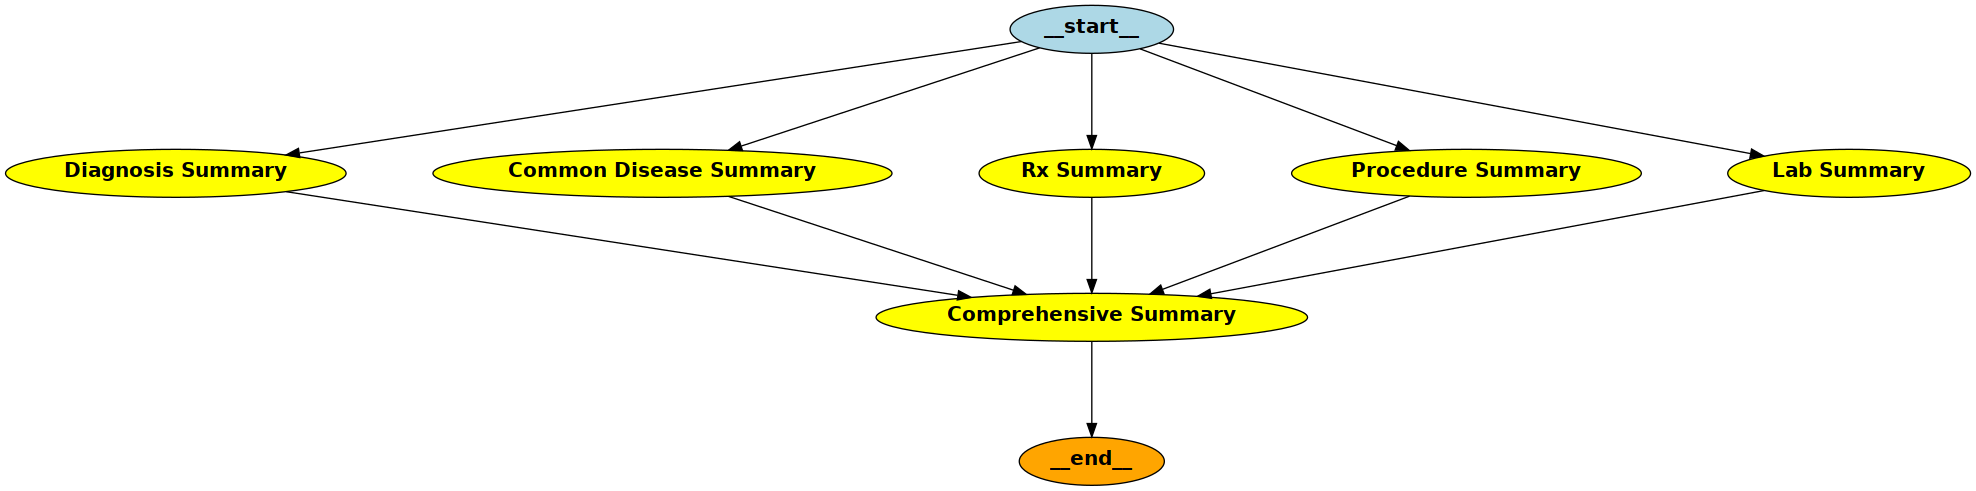

In [35]:
prompt = """You are a smart patient medical codes analyzer. Give a good summary, prioritizing more important information to the top, \
for each type of medical history provided for a patient."""

llm = get_llm('gpt-4o-0806',temperature=0)

summAgent = SummaryAgent(llm, [createLookupTable, createCodeHistory, createLabLookupTable, createLabCodeHistory, returnSpecificICD10DatesCodes], checkpointer=memory, system=prompt)

from IPython.display import Image
Image(summAgent.graph.get_graph().draw_png())

In [36]:
start_summ = {"commonDiseases": ["Kidney Disease", "Diabetes"], "commonDiseaseMapping": dict_disease_mapping, \
              "lookup_dict_diag": dict_obj_diag, "dates_diag": patient[0][0], "codes_diag": patient[0][1], \
              "lookup_dict_lab": dict_obj_lab, "dates_lab": patient[1][0], "codes_lab": patient[1][1], \
              "lookup_dict_rx": dict_obj_rx, "dates_rx": patient[2][0], "codes_rx": patient[2][1], \
              "lookup_dict_proc": dict_obj_proc, "dates_proc": patient[3][0], "codes_proc": patient[3][1], \
              "verbose": 1}

In [37]:
thread = {"configurable": {"thread_id": "1"}}
events_summ = []

start_time = time.time()
for event in summAgent.graph.stream(start_summ, thread):
    for v in event.values():
        events_summ.append(v)
        #print(v)
        
end_time = time.time() - start_time
print("Runtime:", end_time)

['E1122', 'E1151', 'E119', 'E6601', 'E785', 'I10', 'I739', 'J449', 'L0390', 'M179', 'N182', 'S81801A', 'S81801S', 'S81802D', 'Z0000', 'Z6843']
[]
[]
['N182']

content='```markdown\nDiagnosis Summary:\n\nChronic Kidney Disease:\n- Chronic kidney disease, stage 2 (N182) in 2019\n```' response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 258, 'total_tokens': 287}, 'model_name': 'gpt-4o-0806', 'system_fingerprint': 'fp_67802d9a6d', 'finish_reason': 'stop', 'logprobs': None} id='run-bedbaef5-9ebd-40a0-bf04-07d48831f072-0'

['E1122', 'E1151', 'E119']
content='# RX Summary:\n\n## Evaluation and Management:\n- **99214**: Frequent visits from 2017-2019, indicating ongoing management of a potentially serious condition.\n- **99212**: Multiple visits in November 2019, suggesting a period of increased medical attention.\n- **99213**: Visit in 2018, indicating a less intensive evaluation.\n- **99203**: New patient visit in 2017, suggesting initial evaluation.\n\n## Preventive 

In [38]:
#display(Markdown(events_summ[4]['messages'][0].content))

## Recommended Info Testing

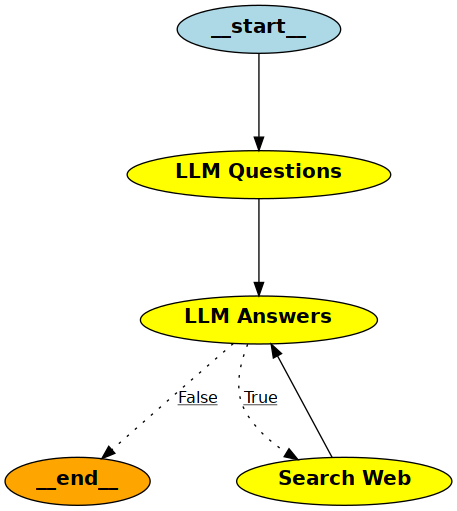

In [39]:
prompt = """You are a smart patient medical codes analyzer. Use the search engine to look up information if needed. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
Only use reputable sources, and when listing the link, write the source name. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

llm = get_llm("gpt-4o-0513")

recommAgent = RecommQAAgent(llm, [tavily], checkpointer=memory, system=prompt)

from IPython.display import Image
Image(recommAgent.graph.get_graph().draw_png())

In [40]:
# thread = {"configurable": {"thread_id": "1"}}
# events_recomm = []

# start_time_1 = time.time()
# for event in recommAgent.graph.stream({"verbose": 1}, thread):
#     for v in event.values():
#         events_recomm.append(v)
#         print(v)
        
# end_time_1 = time.time() - start_time_1
# print(end_time_1)


In [41]:
#display(Markdown(events_recomm[0]['messages'][0].content))

## User Chat Testing

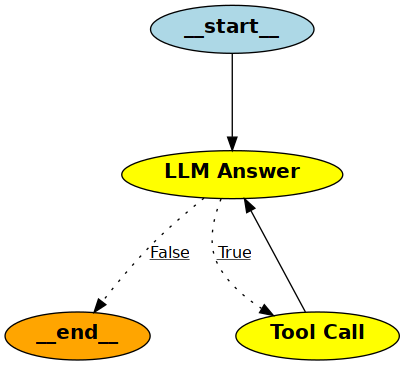

In [42]:
from langgraph.checkpoint.sqlite import SqliteSaver

prompt = """You are a smart medical expert, well versed in medical codes. Use the search engine to look up information. \
Use the lab visualization tool to save a graphed image of a specific lab code (remember to use the exact lab_code name). Graphed image name should be this format 'lab_code.png'. Write image name (e.g. lab_code.png) where it should be displayed. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that! \
Also, insert the graph where it makes sense for the answer to the user's question!
"""

llm = get_llm("gpt-4o-0513")

chatAgent = ChatAgent(llm, [tavily, labViz], checkpointer=memory, system=prompt)

from IPython.display import Image

Image(chatAgent.graph.get_graph().draw_png())

In [43]:
#messages = [HumanMessage(content="What are some serious conditions that the patient is managing, and graph any lab tests that are related please.")]
messages = [HumanMessage(content="can you plot a graph for Creatinine lab test.")]
thread = {"configurable": {"thread_id": "1"}}
events_user = []

for event in chatAgent.graph.stream({"messages": messages, "verbose": 1}, thread):
    for v in event.values():
        events_user.append(v)
        print(v)

content='can you plot a graph for Creatinine lab test.' id='93f5533c-4ed3-4217-a452-ac1985335a23'
[SystemMessage(content="You are a smart medical expert, well versed in medical codes. Use the search engine to look up information. Use the lab visualization tool to save a graphed image of a specific lab code (remember to use the exact lab_code name). Graphed image name should be this format 'lab_code.png'. Write image name (e.g. lab_code.png) where it should be displayed. You are allowed to make multiple calls (either together or in sequence). Only look up information when you are sure of what you want. If you need to look up some information before asking a follow up question, you are allowed to do that! Also, insert the graph where it makes sense for the answer to the user's question!\n"), AIMessage(content='```markdown\n## Diabetes Mellitus and Related Complications\n- Type 2 diabetes mellitus with diabetic chronic kidney disease (E1122) in 2019\n- Type 2 diabetes mellitus with diabet

In [44]:
## Helper functions for loading images

In [45]:
events_user[0]['messages'][0]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VOyXXOXewSLKa7GtundyoepT', 'function': {'arguments': '{"lab_code":"2161-8","lab_description":"Creatinine Urine","dates":["2017-02-08","2018-01-12","2019-01-31"],"lab_values":[154.3,190.1,296.4],"lab_unit_measurement":"mg/dL","plot_name":"creatinine_urine.png"}', 'name': 'labViz'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 2862, 'total_tokens': 2947}, 'model_name': 'gpt-4o-0513', 'system_fingerprint': 'fp_67802d9a6d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1e373f55-51c9-4b28-b50b-f87fc1a18f8b-0', tool_calls=[{'name': 'labViz', 'args': {'lab_code': '2161-8', 'lab_description': 'Creatinine Urine', 'dates': ['2017-02-08', '2018-01-12', '2019-01-22', '2019-01-31', '2019-03-21', '2019-10-31'], 'lab_values': [{'10834-0': 3.4, '13457-7': 110.0, '13458-5': 13.0, '14957-5': 5.2, '1742-6': 21.0, '1751-7': 3.4, '1759-0': 1.0, '17861-6': 9.7, '1920-8': 18

In [46]:
import re

def find_image_filenames(text):
    """Find all image filenames in the given text."""
    return re.findall(r'!\[.*?\]\((.*?)\)', text)

image_names = find_image_filenames(events_user[0]['messages'][0].content)
print(image_names)


[]


In [47]:
from PIL import Image as PIL_Image

def load_images(image_filenames):
    """Load images whose filenames are in the given list."""
    return [PIL_Image.open(fname) for fname in image_filenames]

loaded_images = load_images(image_names)


In [48]:
def pil_images_to_base64(image_filenames):
    """
    Converts a list of PIL images to a list of base64-encoded strings.
    
    Args:
    images (list): List of PIL images.
    
    Returns:
    list: List of base64-encoded strings.
    """
    images = load_images(image_filenames)
    
    img_str_list = []
    
    for i, image in enumerate(images):
        buffer = io.BytesIO()
        
        image.save(buffer, format="PNG")
        buffer.seek(0)
        
        img_str = base64.b64encode(buffer.read()).decode('utf-8')
        markdown_img_str = f"![{image_filenames[i]}](data:image/jpeg;base64,{img_str})"
        
        img_str_list.append(markdown_img_str)
        buffer.close()
        
    return img_str_list

In [49]:
loaded_base64 = pil_images_to_base64(image_names)

In [50]:
import re

def replace_image_markdown(text, new_strings):
    """Replace all image markdowns in the given text with the provided strings."""
    # This is the function that `sub()` will use. It replaces each match with the next string in new_strings
    replace_fn = lambda match: new_strings.pop(0) if new_strings else match.group(0)
    
    # In the text, replace each image markdown using replace_fn
    new_text = re.sub(r'!\[.*?\]\(.*?\)', replace_fn, text)
    
    return new_text
display(Markdown(replace_image_markdown(events_user[-1]['messages'][0].content, loaded_base64)))

Here is the graph for the Creatinine Urine lab test:

![creatinine_urine.png](creatinine_urine.png)

In [51]:
a

NameError: name 'a' is not defined

## Demo: Frontend

In [52]:
import functools

memory_chat = SqliteSaver.from_conn_string(":memory:")
total_events_summ = []

def getSummaries(mcid=0, thread_id = "1"):
    global memory_chat
    global total_events_summ
    
    # Selecting the Patient
    patient = getPatientDatesCodes(mcid)
    llm = get_llm("gpt-4o-0513")

    summAgent = SummaryAgent(llm, [createLookupTable, createCodeHistory, createLabLookupTable, createLabCodeHistory, returnSpecificICD10DatesCodes], checkpointer=memory_chat, system=prompt)

    start_summ = {"commonDiseases": ["Kidney Disease", "Diabetes"], "commonDiseaseMapping": dict_disease_mapping, \
                  "lookup_dict_diag": dict_obj_diag, "dates_diag": patient[0][0], "codes_diag": patient[0][1], \
                  "lookup_dict_lab": dict_obj_lab, "dates_lab": patient[1][0], "codes_lab": patient[1][1], \
                  "lookup_dict_rx": dict_obj_rx, "dates_rx": patient[2][0], "codes_rx": patient[2][1], \
                  "lookup_dict_proc": dict_obj_proc, "dates_proc": patient[3][0], "codes_proc": patient[3][1], \
                  "verbose": 1}

    thread = {"configurable": {"thread_id": thread_id}}
    events_summ = []

    start_time = time.time()
    for event in summAgent.graph.stream(start_summ, thread):
        for v in event.values():
            events_summ.append(v)
            print(v)

    end_time = time.time() - start_time
    total_events_summ.append(events_summ)
    print("Runtime:", end_time)

current_tab = 0
mcids = [None, None, None, None, None]  

llm = get_llm("gpt-4o-0513")

x = ChatAgent(llm, [tavily, labViz], checkpointer=memory_chat, system=prompt)

def get_recomm_qa(mcid=0, thread_id="1"):
    global memory_chat
    
    patient = getPatientDatesCodes(mcid)
    llm = get_llm("gpt-4o-0513")

    recommAgent = RecommQAAgent(llm, [tavily], checkpointer=memory_chat, system=prompt)

    thread = {"configurable": {"thread_id": thread_id}}
    events_recomm = []

    for event in recommAgent.graph.stream({"verbose": 1}, thread):
        for v in event.values():
            events_recomm.append(v)
    
    return events_recomm[0]['messages'][0].content

def show_next_tab(user_input):
    ## Creates next tab
    global current_tab
    value = int(user_input)
    updates = [gr.update(visible=True) if i < current_tab else gr.update(visible=False) for i in range(5)]
    if 0 <= value <= 19:
        if current_tab < 5:
            current_tab += 1
            mcids[current_tab-1] = value
            print(mcids)
            print("thread_id:", current_tab)
            updates = [gr.update(visible=True) if i < current_tab else gr.update(visible=False) for i in range(5)]
            
            getSummaries(mcid=mcids[current_tab-1], thread_id=str(current_tab))
    return updates

    
css = """
h1 {
    text-align: center;
    display:block;
}
"""

with gr.Blocks(fill_height=True, fill_width=True,css=css, theme=gr.themes.Soft(primary_hue=gr.themes.colors.blue, secondary_hue=gr.themes.colors.sky)) as demo:
    gr.Markdown("# MedGPT")
    def respond(message, chat_history, thread_id="1"):
        thread = {"configurable": {"thread_id": thread_id}}
        messages = [HumanMessage(content=message)]
        for event in x.graph.stream({"messages": messages, "verbose": 1}, thread):
            for v in event.values():
                events_user.append(v)

        image_names = find_image_filenames(events_user[-1]['messages'][0].content)
        loaded_base64 = pil_images_to_base64(image_names)
        final_message = replace_image_markdown(events_user[-1]['messages'][0].content, loaded_base64)
        chat_history.append((message , final_message))
        return "", chat_history
    
    def update_content(page_num=1):
        global total_events_summ
        recomm_qa_content = get_recomm_qa(mcid=mcids[page_num-1], thread_id=str(page_num))
        return (
            total_events_summ[page_num-1][0]['messages'][0].content,
            total_events_summ[page_num-1][1]['messages'][0].content,
            total_events_summ[page_num-1][2]['messages'][0].content,
            total_events_summ[page_num-1][3]['messages'][0].content,
            total_events_summ[page_num-1][4]['messages'][0].content,
            total_events_summ[page_num-1][5]['messages'][0].content,
            recomm_qa_content
        )
    
    def hide_content():
        return ("", "", "", "", "", "","")

    
    with gr.Tabs() as tabs:
        with gr.Tab('Patient 1', visible = False, ) as tab1:
            with gr.Column():
                with gr.Tabs() as pageTabs1:
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage1:
                        contentDiag1 = gr.Markdown()
                    with gr.Tab('Common Disease Summary', visible = True) as commPage1:
                        contentComm1 = gr.Markdown()
                    with gr.Tab('Rx Summary', visible = True) as rxPage1:
                        contentRx1 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage1:
                        contentProc1 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage1:
                        contentLab1 = gr.Markdown()
                    with gr.Tab('Summary', visible=True) as SummaryPage1:
                            contentSummary1= gr.Markdown() 
                    with gr.Tab('RecommQA Summary', visible=True) as recommQAPage:
                            contentRecommQA = gr.Markdown()    

                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content, inputs=None, outputs=[contentDiag1, contentComm1, contentRx1, contentProc1, contentLab1,contentSummary1,contentRecommQA])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag1, contentComm1, contentRx1, contentProc1, contentLab1,contentSummary1,contentRecommQA])
            with gr.Column():
                patient1_chat = gr.Chatbot(label="patient1_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                send_button.click(fn=respond, inputs=[text_input, patient1_chat], outputs=[text_input, patient1_chat])

        with gr.Tab('Patient 2', visible = False) as tab2:
            with gr.Column():
                with gr.Tabs() as pageTabs2:
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage2:
                        contentDiag2 = gr.Markdown()
                    with gr.Tab('Common Disease Summary', visible = True) as commPage2:
                        contentComm2 = gr.Markdown()
                    with gr.Tab('Rx Summary', visible = True) as rxPage2:
                        contentRx2 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage2:
                        contentProc2 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage2:
                        contentLab2 = gr.Markdown()
                    with gr.Tab('Summary', visible=True) as SummaryPage2:
                            contentSummary2 = gr.Markdown()     
                    with gr.Tab('RecommQA Summary', visible=True) as recommQAPage:
                            contentRecommQA = gr.Markdown() 

                    update_content2 = functools.partial(update_content, page_num=2)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content2, inputs=None, outputs=[contentDiag2, contentComm2, contentRx2, contentProc2, contentLab2,contentSummary2,contentRecommQA])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag2, contentComm2, contentRx2, contentProc2, contentLab2,contentSummary2,contentRecommQA])
                    
            with gr.Column():
                patient2_chat = gr.Chatbot(label="patient2_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond2 = functools.partial(respond, thread_id="2")
                send_button.click(fn=respond2, inputs=[text_input, patient2_chat], outputs=[text_input, patient2_chat])
            
            
        with gr.Tab('Patient 3', visible = False) as tab3:
            with gr.Column():
                with gr.Tabs() as pageTabs3:
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage3:
                        contentDiag3 = gr.Markdown()
                    with gr.Tab('Common Disease Summary', visible = True) as commPage3:
                        contentComm3 = gr.Markdown()
                    with gr.Tab('Rx Summary', visible = True) as rxPage3:
                        contentRx3 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage3:
                        contentProc3 = gr.Markdown()
                    with gr.Tab('Lab Summary', visible = True) as labPage3:
                        contentLab3 = gr.Markdown()
                    with gr.Tab('Summary', visible=True) as SummaryPage3:
                            contentSummary3 = gr.Markdown() 
                    with gr.Tab('RecommQA Summary', visible=True) as recommQAPage:
                            contentRecommQA = gr.Markdown() 

                    update_content3 = functools.partial(update_content, page_num=3)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content3, inputs=None, outputs=[contentDiag3, contentComm3, contentRx3, contentProc3, contentLab3,contentSummary3,contentRecommQA])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag3, contentComm3, contentRx3, contentProc3, contentLab3,contentSummary3,contentRecommQA])
                    
            with gr.Column():
                patient3_chat = gr.Chatbot(label="patient3_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond3 = functools.partial(respond, thread_id="3")
                send_button.click(fn=respond3, inputs=[text_input, patient3_chat], outputs=[text_input, patient3_chat])
                   
        with gr.Tab('Patient 4', visible = False) as tab4:
            with gr.Column():
                with gr.Tabs() as pageTabs4:
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage4:
                        contentDiag4 = gr.Markdown()
                    with gr.Tab('Common Disease Summary', visible = True) as commPage4:
                        contentComm4 = gr.Markdown()
                    with gr.Tab('Rx Summary', visible = True) as rxPage4:
                        contentRx4 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage4:
                        contentProc4 = gr.Markdown()
                    with gr.Tab('Summary', visible=True) as SummaryPage4:
                            contentSummary4 = gr.Markdown() 
                    with gr.Tab('Lab Summary', visible = True) as labPage4:
                        contentLab4 = gr.Markdown()

                    update_content4 = functools.partial(update_content, page_num=4)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content4, inputs=None, outputs=[contentDiag4, contentComm4, contentRx4, contentProc4, contentLab4,contentSummary4,contentRecommQA])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag4, contentComm4, contentRx4, contentProc4, contentLab4,contentSummary4,contentRecommQA])
                    
            with gr.Column():
                patient4_chat = gr.Chatbot(label="patient4_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond4 = functools.partial(respond, thread_id="4")
                send_button.click(fn=respond4, inputs=[text_input, patient4_chat], outputs=[text_input, patient4_chat])
                        
        with gr.Tab('Patient 5', visible = False) as tab5:
            with gr.Column():
                with gr.Tabs() as pageTabs5:
                    with gr.Tab('Diagnosis Summary', visible = True) as diagPage5:
                        contentDiag5 = gr.Markdown()
                    with gr.Tab('Common Disease Summary', visible = True) as commPage5:
                        contentComm5 = gr.Markdown()
                    with gr.Tab('Rx Summary', visible = True) as rxPage5:
                        contentRx5 = gr.Markdown()
                    with gr.Tab('Procedure Summary', visible = True) as procPage5:
                        contentProc5 = gr.Markdown()
                    with gr.Tab('Summary', visible=True) as SummaryPage5:
                            contentSummary5 = gr.Markdown() 
                    with gr.Tab('Lab Summary', visible = True) as labPage5:
                        contentLab5 = gr.Markdown()

                    update_content5 = functools.partial(update_content, page_num=5)
                    show_summaries_button = gr.Button("Show Summaries")
                    show_summaries_button.click(fn=update_content5, inputs=None, outputs=[contentDiag5, contentComm5, contentRx5, contentProc5,contentSummary5, contentLab5,contentRecommQA])
                    
                    hide_summaries_button = gr.Button("Hide Summaries")
                    hide_summaries_button.click(fn=hide_content, inputs=None, outputs=[contentDiag5, contentComm5, contentRx5, contentProc5, contentLab5,contentSummary5,contentRecommQA])
                    
            with gr.Column():
                patient5_chat = gr.Chatbot(label="patient5_chatbot", height=800)
                with gr.Row():
                    text_input = gr.Textbox(label="Your Message")
                    send_button = gr.Button("Send")
                respond5 = functools.partial(respond, thread_id="5")
                send_button.click(fn=respond5, inputs=[text_input, patient5_chat], outputs=[text_input, patient5_chat])
            
                    
    user_input = gr.Textbox(label="Enter mcid for new chat:")
    new_chat_btn = gr.Button("New Chat")
    
    
    new_chat_btn.click(fn=show_next_tab, inputs=user_input, outputs=[tab1, tab2, tab3, tab4, tab5])
    
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7864
Running on public URL: https://4fffd875551c648910.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[15, None, None, None, None]
thread_id: 1
['B079', 'D126', 'E119', 'E782', 'F17200', 'F17218', 'F411', 'G8929', 'J309', 'J449', 'K219', 'K760', 'L299', 'L819', 'L920', 'L989', 'M25512', 'M25561', 'M47896', 'M542', 'M545', 'N281', 'R1012', 'R1084', 'R109', 'R208', 'R238', 'R918', 'R945', 'S39011A', 'S8392XA', 'W010XXA', 'Y9354', 'Z1231', 'Z6833', 'Z7984', 'Z79899', 'Z800']
[]
[]
[]
['E119']

content='### Diagnosis Summary:\n\n#### Endocrine, Nutritional, and Metabolic Diseases:\n- Type 2 diabetes mellitus without complications (E119) in 2019\n\nThe patient has a history of Type 2 diabetes mellitus without complications, with multiple diagnoses recorded throughout 2019.' response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 415, 'total_tokens': 472}, 'model_name': 'gpt-4o-0513', 'system_fingerprint': 'fp_67802d9a6d', 'finish_reason': 'stop', 'logprobs': None} id='run-6c4abba3-a436-4bcc-9b2e-756cc873f888-0'

content="To summarize the 'Patient Procedure Code History'